# Intorduction to the LCCS Taxonomy  <img align="right" src="Supplementary_data/dea_logo.jpg">




The United Nations Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS) is a method of classifying land cover based on environmental variables. It was designed to be translatable across different continents and ecosystems and to be interpretable by non-ecologists. Although the LCCS was originally designed to be used with ground based survey data the Earth Observation Data for Ecosystem Monitoring (EODESM) project, a collaboration between Aberystwyth University and Digital Earth Australia, demonstrated how LCCS can be generated from remotely sensed data  [Lucas et al. 2019](https://www.mdpi.com/2306-5729/4/4/143). This notebook provides an introduction to producing a LCCS classification with satellite data. Using band-math indexes it steps through generating input layers from Landsat 8 data. These input layers are used to determine the presence or absence of environmental variables, such as water and vegetation, which are used to make the classification.

### How LCCS works
The LCCS is defined by the taxonomy outlined in the following classification tree (figure 1) which consists of two main sections; the Dichotomous phase and the Modular-hierarchical phase. The Dichotomous phase makes simple branching decisions separating land cover classes on the presence or absence of given environmental variables resulting in a classificaiton of 8 classes. A classification only as far as the bottom of the Dichotomous phase is referred to as a Level 3 classification. Digital Earth Australia does not separate open water into 'natural' water bodies and 'artificial' water bodies and as such only includes 7 classes in the level 3 classification. The Modular-hierarchical phase takes these level 3 classes and applies additional attributes to further describe these base classes. The attributes included in the Modular-hierarchical phase deffer between each of the broader level three classes and are also not limited to binary classifications.

<img src="LCCS_figures/LCCS taxonomy from lucas et al 2019.jpg">

    Figure 1: the FAO Land Cover Classification System  taxonomy from Lucas et al. 2019.


It is possible to classify only as deeply in the LCCS as available data will allow; In this workflow we will be generating a Level 3 classification by making decisions on the presence or absence of four biophysical properties: Vegetation, water, the urban environment and cultivated vegetation. Figure 2 shows the classification steps this notebook will be following.

<img src="LCCS_figures/LCCS taxonomy aus_lv3 2.jpg">

    Figure 2: truncated level 3 LCCS classification that this notebook will be following.

magpie

## Using this Notebook

### what do I need to run it?
This notebook can be run either using a data load from Digital Earth Australia (DEA) or using a user supplied Landsat scene geotiff. The defult is to run using a geotiff, and an example geotiff is supplied. The code can be used on a single observation to classifly landcover for a point in time or it can be run on a composite image generated from a year or a season's worth of observations.

The way this code is written makes a number of assumptions about the geotiff being used and they are listed in the next section. Code to load data from DEA is supplied but commented out, to run the notebook this way it will need to replace the geotiff loading code.

#### Geotiff Requerments

This notbook assumes it is running on a single time landsat multiband geotiff containing bands listed in table 1 in the order described. The code assumes cloud masking has already be applied and that any NoData has been saved with a value of -9999. To insert your own Geotiff upload it to the sandbox and replace the path file of the example geotiff in the next cell: 



In [1]:
Geotiff_file_path = 'LCCS_example.tif'



<img src="LCCS_figures/band table.jpg">

    Table 1: Geotiff structure
The code assumes the geotiff contains these bands in this order. If you wish to use a geotiff with a different order of bands you will need to change the band name assignment in the second cell of section 1 to match the correct order.

### Indexes and thresholds used
This notebook provides an introduction to producing a LCCS classification with satellite data. The band math indexes used to generate input layers were chosen for a balance between accuracy and ease of use; they are commonly used remote sensing indexes that do not require a lot of computational power or time to generate. However, the accuracy of these indexes in all ecosystems is limited. Thresholds used here may need to be adjusted to suit different landscapes. User exploration and adjustment is encouraged and different indexes or models that provide a better result should be substituted when avalible.


## Description
This notebook will run through the process of generating a Land cover classification of up to five classes using simple index models to generate input layers. The notebook will run through the following steps:

1. Loading a Geotiff of a chosen area

    - Optional: load from Digital Earth Australia or other Datacube


2. Generate indexes and apply thresholds
    - a) Vegetation
    - b) Water
    - c) Urban
    - d) Cultivated Vegetation
    

3. Combine Input layers to generate classification

4. Exporting and visualising classification
    - a) Save classification to single band Geotiff
    - b) Visualise as RGB Image
    

5. Customising the Classification

***

### Load packages
Import Python packages that are used for the analysis.

In [2]:
%matplotlib inline

import sys
import datacube
from datacube.utils.cog import write_cog
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


In [3]:
dc = datacube.Datacube(app="Baby LCCS")

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## 1. Loading Geotiff

A Geotiff of the chosen study area is loaded as an Xarray Dataset and the bands are given readable names.

In [4]:
# Open into an xarray.DataArray
geotiff_data = xr.open_rasterio(Geotiff_file_path)

# Covert our xarray.DataArray into a xarray.Dataset
geotiff_ds = geotiff_data.to_dataset('band')

__This is where you will need to change the mapping of band numbers and band names if needed__

In [5]:
# Rename the variables to match the band names used in equations.
Band_names = {1: 'blue', 2: 'green', 3: 'red', 4: 'nir', 5: 'swir1', 6: 'swir2'}

ds = geotiff_ds.rename(Band_names)

# Replace any -9999 No data with np.Nan values 
ds = ds.where(ds != -9999)

ds

<xarray.Dataset>
Dimensions:  (x: 1426, y: 1664)
Coordinates:
  * y        (y) float64 -3.94e+06 -3.94e+06 -3.94e+06 ... -3.981e+06 -3.981e+06
  * x        (x) float64 1.532e+06 1.532e+06 1.532e+06 ... 1.567e+06 1.567e+06
Data variables:
    blue     (y, x) float64 392.0 404.0 403.0 411.0 ... 510.0 503.0 514.0 474.0
    green    (y, x) float64 716.0 716.0 705.0 729.0 ... 864.0 854.0 863.0 811.0
    red      (y, x) float64 736.0 751.0 739.0 781.0 ... 980.0 962.0 1e+03 934.0
    nir      (y, x) float64 3.183e+03 3.171e+03 ... 2.878e+03 2.672e+03
    swir1    (y, x) float64 2.929e+03 2.79e+03 2.856e+03 ... 2.628e+03 2.52e+03
    swir2    (y, x) float64 1.706e+03 1.65e+03 1.667e+03 ... 1.522e+03 1.464e+03
Attributes:
    transform:      (25.0, 0.0, 1531825.0, 0.0, -25.0, -3939575.0)
    crs:            +init=epsg:3577
    res:            (25.0, 25.0)
    is_tiled:       1
    nodatavals:     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

### Optional: load from Digital Earth Australia or other Datacube

Use this code to select a study area and load the data from DEA. To do this, comment out the code above that loads from a geotiff and uncomment the code in the following two cells. To quickly toggle commenting on/off for a large block of code in the sandbox select it and press __Ctrl__ +  __/__

In [6]:
# #DEA 'Scripts' files will need to be avalibe on your sandbox to use the display map fuction.
# #this help to visualise the study area prior to loading the data but is not nessisary
# sys.path.append('Scripts')
# from dea_plotting import display_map

# # Set the central latitude and longitude of study area
# central_lat = -35.3080
# central_lon = 149.1242

# # Set the buffer to load around the central coordinates.
# buffer = 0.17

# # Compute the bounding box for the study area
# study_area_lat = (central_lat - buffer, central_lat + buffer)
# study_area_lon = (central_lon - buffer, central_lon + buffer)

# display_map(x=study_area_lon, y=study_area_lat)

In [7]:
# # Load available data 
# #for dev perposes using a geomedian to avoid having to cloudmask/ serch for a clear image
# ds = dc.load(product="ls8_nbart_geomedian_annual", 
#              x=study_area_lon,
#              y=study_area_lat,
#              time=("2015"))

# ds

## 2. Generate indexes and apply thresholds:

### a) Vegetation 

The suggested model for identifying the presence or absence of vegetation is the Normalised Difference Vegetation Index (NDVI) (Rouse jr. et al. 1974). In the example area a threshold of  +0.4 NDVI to define vegetation is suggested. This is to maximise the mapping of urban areas becasue much of the the leafy suburbs of Canberra have an NDVI value in the low positive range. A lower threshold may be more appropreate for an area with sparser and dryer vegetation, or if the deliniation between sparse vegetaton and bare soil is more important to the user.

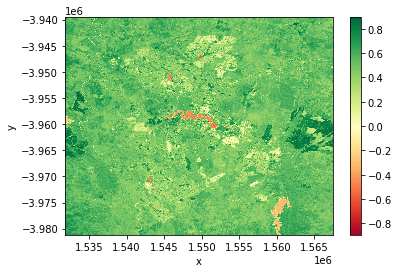

In [8]:
# Calculate and plot the Normalised Difference Vegetation Index
NDVI = (ds.nir - ds.red) / (ds.nir + ds.red)
NDVI.plot(cmap='RdYlGn')

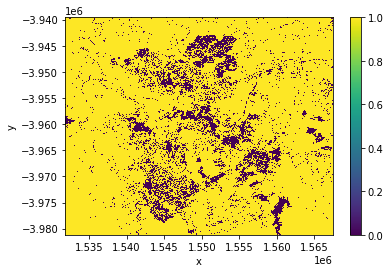

In [9]:
# Define and apply threshold. 

vegetation_threshold = 0.4 # Modify this to change NDVI threshold 

vegetated = NDVI >= vegetation_threshold
non_vegetated = NDVI < vegetation_threshold

# Plot to visualize vegetation input layer
vegetated.plot() # 1 = vegetated, 0 = not vegetated

### b) Water

The suggested model for identifying open water is the Modified Normalised Difference Water Index (MNDWI) (Xu, H. 2006). 0 is usually recommended as the threshold for identifying water in Landsat imagery.

If this notebook is being run over an area of interest that contains significant aquatic vegetation, using MNDWI alone may not be sufficient to capture it. The mixed water-vegetation signal of aquatic vegetation is difficult to identify in optical remote sensing, in indexes such as NDVI and MNDVI, water and vegetation represent the end-members of the indexes. The recommended index for identifying mixed water-vegetation is the Tasseled Cap Wetness Index (Crist, E.P. 1985). This index does have limitations in non-aquatic areas and so the inclusion of it is only recommended if needed. Common false positives for aquatic vegetation when using this index include very green dense forests and vegetation that is always in hill-shade. Its use is not reccomended in the example area as Canberra doesn't have significant areas of aquatic vegetation. 

A threshold for identifying aquatic vegetation with Tasseled Cap Wetness should be around -300, with values greater than that being wet. Raise the threshold for a more conservative detection and lower it for greater sensitivity.

__In order to include use of this index insure the aquatic vegetation flag is switched to true.__


In [10]:
# Aquatic vegetation flag:
look_for_aquatic_vegetation = False

# Set threshold used for Tasseled Cap Wetness
aquatic_veg_threshold = -200

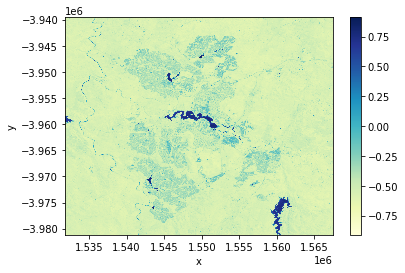

In [11]:
# Calculate and plot the Modified Normalised Difference Water Index
MNDWI = (ds.green - ds.swir1) / (ds.green + ds.swir1)
MNDWI.plot(cmap = 'YlGnBu')

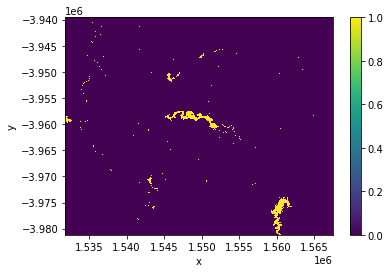

In [12]:
if look_for_aquatic_vegetation == True:
    
    # Calculate Tasseled Cap Wetness to find mixed wet vegetation signals
    wetness_tasseled = 0.0315 * ds.blue + 0.2021 * ds.green + 0.3102 * ds.red + 0.1594 * ds.nir + (-0.6806 * ds.swir1) + (-0.6109 * ds.swir2)
    
    # Define water based on BOTH indexes
    water = (np.logical_or(MNDWI > 0, wetness_tasseled > aquatic_veg_threshold)) * 1
    not_water = (water == 0) * 1
    
else:
    # Define water ONLY on MNDWI
    water = (MNDWI > 0) * 1
    not_water = (water == 0) * 1
    
water.plot()

### c) Built Environment

The purpose of this input layer is to differentiate built-up areas from natural bare surfaces. These two environments look very similar in optical remote sensing as they are both hard, bright surfaces made from similar components. The suggested index for this input layer is the Modified Built Index (MBI) from Can Trong Nguyen et al 2021 with built areas having a MBI value less than +0.27 and natural bare surfaces having a higher MBI.

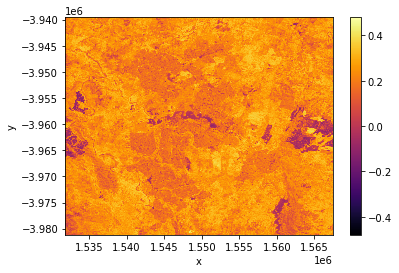

In [13]:
# Calculate & plot the Modified Built Index
MBI = ((ds.swir1 - ds.swir2 - ds.nir) / (ds.swir1 + ds.swir2 + ds.nir)) + 0.5  
MBI.plot(cmap='inferno')

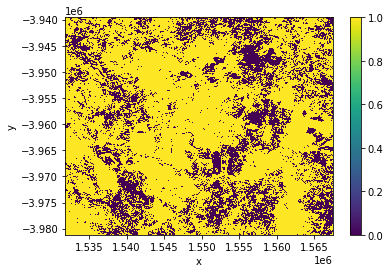

In [14]:
# Apply threshold to MBI
urban =  (MBI < 0.27) * 1
urban.plot()

### D. Cultivated Vegetation

It is difficult to accurately detect cultivated vegetation from a single landsat scene. For this example a simple model using very high NDVI is used. This is based on the assumption that very high NDVI value is an indicator of irrigation in this environment. For the example area this assumption mostly holds, setting an NDVI thershold of +0.75 isolates golf courses, playing fields and pine plantations.

More complex models based on plant phenology could be used here for a more accurate result. 

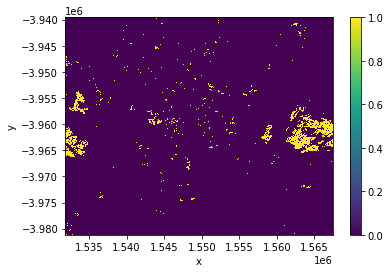

In [15]:
# Define and apply threshold. 

cultivated_threshold = 0.75 # Modify this to change NDVI threshold 

cultivated = NDVI >= cultivated_threshold
non_cultivated = NDVI < cultivated_threshold

# Plot to visualize vegetation input layer
cultivated.plot() # 1 = vegetated, 0 = not vegetated

## 3. Combine Input layers to generate classification




Now that all input layers have been generated they can be used to generate the classification. 

<img src="LCCS_figures/LCCS taxonomy truncated w divisions 3.jpg">

    Figure 3: truncated level 3 LCCS classification with seperate division steps highlighted

The first division in the classification tree, the split between vegetated and non-vegetated was conducted when NDVI was thresholded in step 2a. the outputs from this division can now be combined with the water input layers to produce the second level of divisions. First we will do the division on the left hand side: dividing Vegetated into Terrestrial_Veg and Aquatic_Veg:


In [16]:
# Terrestrial vegetated is defined by where it is vegetated and not water
terrestrial_veg = vegetated * not_water

# Aquatic vegetated is where there is both vegetation and water
aquatic_veg = vegetated * water 

Next the right hand side of the second division; combining the water input layers with the non-vegetated layer.

In [17]:
# Where there is neither vegetation or water
terrestrial_non_veg = non_vegetated * not_water 

# Where there no vegetation but water is present
aquatic = non_vegetated * water


Division three is conducted by combining the terrestrial_non_veg layer with the urban input layer

In [18]:
# Everywhere meets the MBI threshold that is not water or veg
artificial_surfaces = terrestrial_non_veg * urban 

# Everywhere that is terrestrial_non_veg, minus the part classified as artificial_surfaces.
natural_bare = terrestrial_non_veg - artificial_surfaces 

Lastly, division four is conducted by defining Cultivated Terrestrial Vegetation by where Terrestrial_Veg meets the cultivated threshold. Natural Terrestrial Vegetation is defined as all remaining Terrestrial_Veg. 

In [19]:
cultivated_t_veg = terrestrial_veg * cultivated

natural_t_veg = terrestrial_veg - cultivated_t_veg

Now that all classifictions have been completed The LCCS class codes can be applied to the classes and the classes combined into one layer. In order to be able to combine all classes in one layer the code assigns each class it's three didgit LCCS class number, as defined by Table 2.

<img src="LCCS_figures/Table_2_class_codes_w_colours.jpg">

    Table 2: LCCS level 3 class codes, along with corresponding class names and RGB values for plotting a false colour image.

In [20]:
# Define layers with LCCS class numbers

cultivated_terrestrial_vegetation = cultivated_t_veg * 111
natural_terrestrial_vegetation = natural_t_veg  * 112
aquatic_vegetation = aquatic_veg * 124
artificial_surfaces_layer = artificial_surfaces * 215
natural_bare_layer = natural_bare * 216
aquatic_layer = aquatic * 220

# Combine layers into one
LCCS_classes = (cultivated_terrestrial_vegetation + 
               natural_terrestrial_vegetation + 
               aquatic_vegetation + artificial_surfaces_layer + 
               natural_bare_layer + aquatic_layer)

# Set data type so it can be saved as geotiff
LCCS_classes = LCCS_classes.astype('int16')

## 4. Exporting and visualising classification


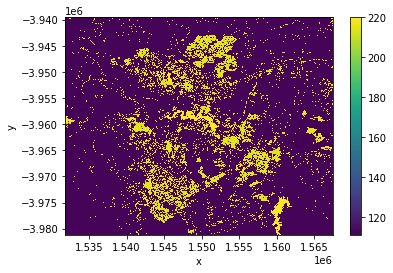

In [21]:
# Visualise classification

LCCS_classes.plot()

The Final classification can also be visualised in the notebook using the plot function above. However becasue of the disstribution on the LCCS codes the defult colour maps do not provide much insight about some of the classes; Becasue they are numericaly so close together Artificial Surfaces(215), Natural Bare(216) and Water(220) are all plotting as the same colour. To properly visualise and investigate the classification it can be saved as a single band geotiff that can be downloaded to a local computer and opened in ArcGIS or QGIS. This code will save the geotiff with the pixel values equal to the corresponding three digit LCCS class codes, that can then be easily visualised in those programs. 

In [22]:
# write_cog saves a DataArray as a Geotiff - comment out if you don't wish to
# write_cog(LCCS_classes, 'lccs_classes.tif')

### Plotting as a false colour RGB image

Another option to visualise the resulting classification is to generate a false colour RGB image with each LCCS class assigned an appropriate colour. In order to do this we need to generate Red, Green and Blue bands to combine together. The following code generates these bands by multiplying the individual class layers by a value for red, green, and blue respectively and then combining them into red, green, and blue layers. The values used to generate the representative colours are those listed in table 2. 

In [23]:
# Generate red band
red_nat_terrestrial_veg = natural_t_veg * 14
red_cultivated_t_veg = cultivated_t_veg * 151
red_aquatic_veg = aquatic_veg * 30
red_artificial_surfaces = artificial_surfaces * 218
red_natural_bare = natural_bare * 243
red_aquatic = aquatic * 77

red_band = red_nat_terrestrial_veg + red_cultivated_t_veg + red_aquatic_veg + red_artificial_surfaces + red_natural_bare + red_aquatic

# Generate green band
green_nat_terrestrial_veg = natural_t_veg * 121
green_cultivated_t_veg = cultivated_t_veg * 187
green_aquatic_veg = aquatic_veg * 191
green_artificial_surfaces = artificial_surfaces * 92
green_natural_bare = natural_bare * 171
green_aquatic = aquatic * 159

green_band = green_nat_terrestrial_veg + green_cultivated_t_veg + green_aquatic_veg + green_artificial_surfaces + green_natural_bare + green_aquatic

# Generate blue band
blue_nat_terrestrial_veg = natural_t_veg * 18
blue_cultivated_t_veg = cultivated_t_veg * 26
blue_aquatic_veg = aquatic_veg * 121
blue_artificial_surfaces = artificial_surfaces * 105
blue_natural_bare = natural_bare * 105
blue_aquatic = aquatic * 220

blue_band = blue_nat_terrestrial_veg + blue_cultivated_t_veg + blue_aquatic_veg + blue_artificial_surfaces + blue_natural_bare + blue_aquatic

<function matplotlib.pyplot.show(*args, **kw)>

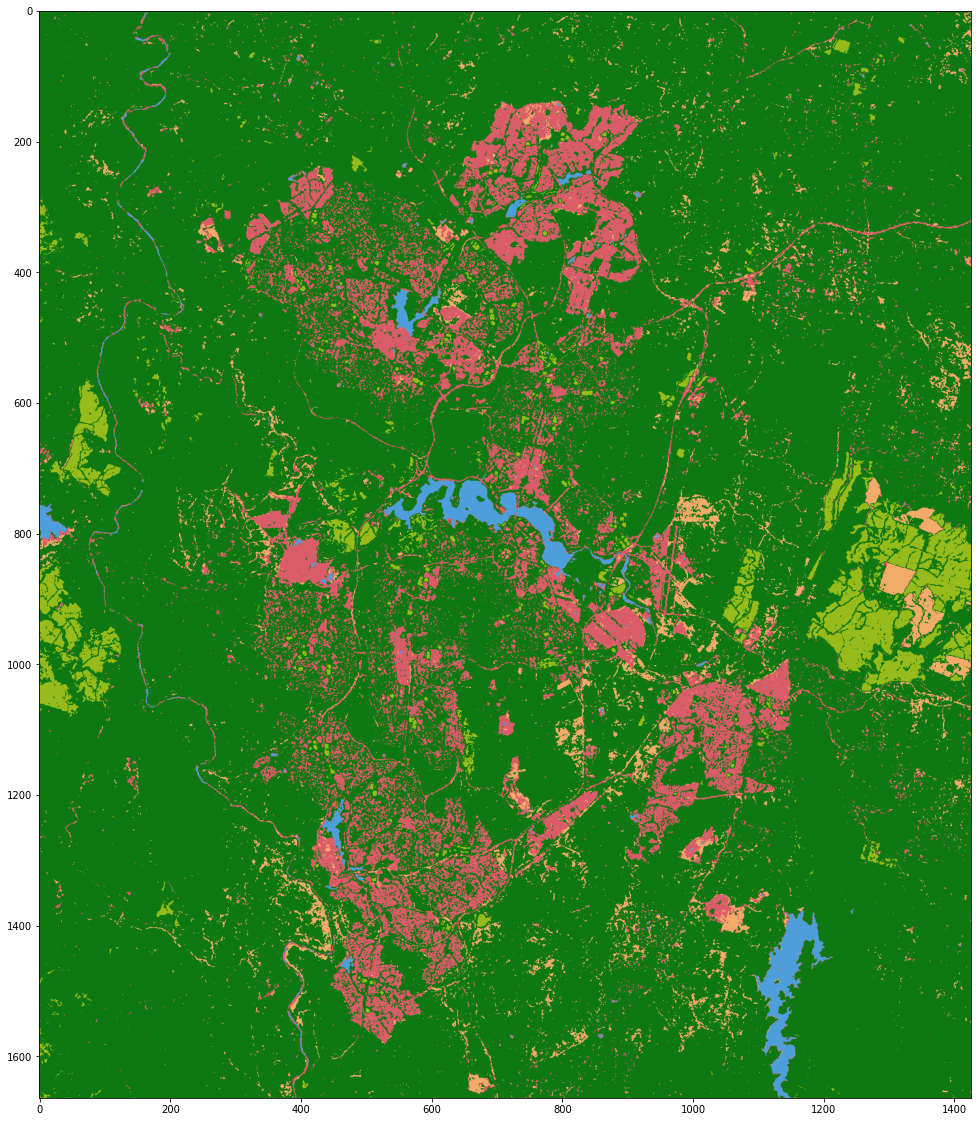

In [24]:
# Combine red green and blue into a single Dataset 
LCCS_RGB = xr.Dataset({'red':red_band, 'green':green_band, 'blue':blue_band}).astype('int16')

# Plot RGB image
plt.figure(figsize=(20,20)) # Set size so it's not tiny
plt.imshow(LCCS_RGB.to_array().transpose('y','x','variable'))
plt.show

## Customising the Classification

This notebook is designed to provide an introduction to producing an LCCS classification with satellite data using Python. The models used to generate the input layers here are intentionally simple and generalised. Replacing them with more complex models that have been developed for specific ecosystems will provide a better result in those areas. Once you have an understanding of the process and how the code runs you can change it and optimise it for your area of interest and use case. One strength of the LCCS is that data from multiple sensors or sources can be combined. Therefore models developed using other data sources such as higher resolution surface reflectance, Synthetic Apature Radar or even LiDar can be added to refine or further the classification. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2021

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)